# Proste klasyfikatory do predykcji

### Zmienne i wymagane biblioteki

In [ ]:
import matplotlib.pyplot as plt # Wyświetlanie obrazów
import cv2 # Operacje na obrazach
import numpy as np # Operacje na macierzach
from sklearn.neighbors import KNeighborsClassifier # Klasyfikator KNN
from os import listdir # Wyświetlanie zawartości folderu
from random import randint, seed # Zapewnienie losowości
from tqdm.notebook import tqdm # Pasek postępu
import math # Funkcje matematyczne do normalizacji momentów Hu

%matplotlib inline

# Folder z obrazami do dodania do klasyfikatora
TRAIN_DIR = 'train/images'
# Folder z obrazami do testów klasyfikatora
TEST_DIR = 'test/images'
# Folder z maskami eksperckimi do treningu
TRAIN_MASKS_DIR = 'train/ground_truth'
# Folder z maskami eksperckimi do ewaluacji jakości klasyfikatora
TEST_MASKS_DIR = 'test/ground_truth'
# Rozmiar obrazu podczas działania algorytmu
img_size = (1024, 1024)
# Rozmiar fragmentu używanego do testów i treningu (musi być liczbą nieparzystą!)
sample_size = 5

### Wycinanie podobrazów

In [32]:
size = 5 # Rozmiar obrazu
x = 0
y = 0
# Przykładowy obraz...
example_img = np.eye(size)
print(example_img)
# rozszerzony o rozmiar podobrazu który ma zostać wycięty
expanded_img = np.pad(example_img, [(size // 2, size // 2), (size // 2, size // 2)], 'constant', constant_values=(0,0))
print(expanded_img)

[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [33]:
# Wypisz co znajduje się w pikselu na pozycji (x, y)
print(expanded_img[x + size // 2][y + size // 2])
# Zamień ten piksel na niepowtarzalną wartość dla lepszej wizualizacji (powinien być w centrum)
expanded_img[x + size // 2][y + size // 2] = 5
# Wypisz wycięty fragment
print(expanded_img[x:x+size, y:y+size])

1.0
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 5. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]


In [34]:
def get_fragment(img, x, y, size):
    '''
    Wytnij podobraz tak, aby (x,y) było centralnym pikselem. Należy obraz rozszerzyć aby zapobiec wychodzeniu poza obraz.
    :param img: - obraz, z którego ma zostać wycięty podobraz
    :param x: - współrzędna OX środkowego piksela wycinka
    :param y: - współrzędna OY środkowego piksela wycinka
    :param size: - szerokość i wysokość wycinka
    '''
    expanded_image = np.pad(img, [(size // 2, size // 2), (size // 2, size // 2)], 'constant', constant_values=(0,0))
    return expanded_image[x:x+size, y:y+size]

### Funkcje pomocnicze

In [35]:
def join_tables(tables):
    '''
    Scalanie tablic. Przykładowo dla tablicy:
    [[0, 1, 2],
     [1, 3, 4]]
    Zwróci [0, 1, 2, 1, 3, 4].
    :param tables: - tablice do złączenia
    '''
    result = []
    for table in tables:
        result.extend(table)
    return result

In [36]:
def get_label(img, x, y):
    '''
    Wyciągnij predykcję z maski dla współrzędnych x i y. Jeżeli piksel jest biały, jest to żyła. W przeciwnym wypadku zwróć 0.
    :param img: - obraz maski
    :param x: - współrzędna OX badanego piksela
    :param y: - współrzędna OY badanego piksela
    '''
    return 1 if img[x][y] == 255 else 0

In [51]:
def get_moments(sample):
    '''
    Wyciągnij momenty Hu z podobrazka
    :param sample: - podobrazek (dowolnej wielkości)
    '''
    moments = cv2.moments(sample)
    huMoments = cv2.HuMoments(moments)
    for idx, moment in enumerate(huMoments):
        if moment[0] == 0:
            huMoments[idx][0] = 0
        else:
            huMoments[idx][0] = -1 * math.copysign(1.0, moment[0]) * math.log10(abs(moment[0]))
    return [ elem[0] for elem in huMoments ]

In [56]:
def get_set_prediction(img, model):
    '''
    Uzyskaj predykcję dla podobrazka na podstawie jego momentów Hu.
    :param img: - podobrazek wejściowy
    :param model: - klasyfikator wykonujący predykcję
    '''
    moments = get_moments(img)
    return model.predict([moments])[0]

In [39]:
def get_prediction(img, model):
    '''
    Uzyskaj predykcję dla podobrazka na podstawie jasności pikseli.
    :param img: - podobrazek wejściowy
    :param model: - klasyfikator wykonujący predykcję
    '''
    return model.predict([join_tables(img)])[0]

In [40]:
def get_samples(img, mask, sample_size, maxSamples = 200, guaranteedVeins = 50):
    '''
    Funkcja dzieląca obraz na podobrazki, a następnie łącząca jasności ich pikseli w jedną tabelę, która będzie wykorzystana do
    klasyfikacji. Następnie wyznaczane są oznaczenia zestawu danych (czy jest żyłą czy nie na podstawie maski).
    :param img: - obraz wejściowy
    :param mask: - maska ekspercka
    :param sample_size: - rozmiar podobrazów
    :param maxSamples: - maksymalna liczba próbek per obraz
    :param guaranteedVeins: - ile minimum próbek MUSI być żyłami
    '''
    result = [[], []]
    seed(42) # Zapewnienie losowości
    veinsSoFar = 0
    samples = 0
    
    while (samples < maxSamples):
        # Losowanie centralnego piksela
        x = randint(0, img.shape[0] - 1)
        y = randint(0, img.shape[1] - 1)
        # Wyciąganie oznaczenia
        label = get_label(mask, x, y)
        # Zapewnij, że liczba pozytywnych próbek wyniesie minimum guaranteedVeins
        if label == 1 and veinsSoFar < guaranteedVeins:
            veinsSoFar += 1
            # Dane do klasyfikatora
            fragment = get_fragment(img, x, y, sample_size)
            # Zapisz jasności pikseli podobrazu
            result[0].append(join_tables(fragment))
            # Zapisz predykcję
            result[1].append(label)
            samples += 1
        # Po spełnieniu wymogu minimalnych pozytywnych próbek, postępuj standardowo
        elif veinsSoFar >= guaranteedVeins:
            fragment = get_fragment(img, x, y, sample_size)
            result[0].append(join_tables(fragment))
            result[1].append(label)
            samples += 1

    return result

In [41]:
def get_set_samples(img, mask, sample_size, maxSamples = 200, guaranteedVeins = 50):
    '''
    Funkcja dzieląca obraz na podobrazki, a następnie wyliczająca ich momenty Hu, które będą wykorzystane do
    klasyfikacji. Następnie wyznaczane są oznaczenia zestawu danych (czy jest żyłą czy nie na podstawie maski).
    :param img: - obraz wejściowy
    :param mask: - maska ekspercka
    :param sample_size: - rozmiar podobrazów
    :param maxSamples: - maksymalna liczba próbek per obraz
    :param guaranteedVeins: - ile minimum próbek MUSI być żyłami
    '''
    result = [[], []]
    seed(42) # Zapewnienie losowości
    veinsSoFar = 0
    samples = 0
    
    while (samples < maxSamples):
        # Losowanie centralnego piksela
        x = randint(0, img.shape[0] - 1)
        y = randint(0, img.shape[1] - 1)
        # Wyciąganie oznaczenia
        label = get_label(mask, x, y)
        # Zapewnij, że liczba pozytywnych próbek wyniesie minimum guaranteedVeins
        if label == 1 and veinsSoFar < guaranteedVeins:
            veinsSoFar += 1
            # Dane do klasyfikatora
            fragment = get_fragment(img, x, y, sample_size)
            # Zapisz jasności pikseli podobrazu
            result[0].append(get_moments(fragment))
            # Zapisz predykcję
            result[1].append(label)
            samples += 1
        # Po spełnieniu wymogu minimalnych pozytywnych próbek, postępuj standardowo
        elif veinsSoFar >= guaranteedVeins:
            fragment = get_fragment(img, x, y, sample_size)
            # Zapisz momenty Hu
            result[0].append(get_moments(fragment))
            # Zapisz predykcję
            result[1].append(label)
            samples += 1

    return result

### Trenowanie klasyfikatora KNN

In [26]:
train_data = []
train_labels = []
data = []

num_images = len(listdir(TRAIN_DIR))
for image in tqdm(listdir(TRAIN_DIR)):
    # Wczytywanie obrazu
    img = cv2.imread(f'{TRAIN_DIR}/{image}', cv2.IMREAD_COLOR)
    # Zmniejsz rozmiar
    img = cv2.resize(img, img_size)
    # Wyciągnij kanał zielony (ma najlepszy kontrast żył do reszty obrazu)
    _, img, _ = cv2.split(img)
    # Wyrównaj histogram kolorów
    img = cv2.equalizeHist(img)

    # Wczytaj maskę
    mask = cv2.imread(f'{TRAIN_MASKS_DIR}/{image.split(".")[0] + ".tif"}', cv2.IMREAD_GRAYSCALE)
    # Zmniejsz rozmiar
    mask = cv2.resize(mask, img_size)

    # Wyciągnij dane dla klasyfikatora
    data = get_samples(img, mask, sample_size, 200, 75)

    train_data += data[0]
    train_labels += data[1]

# Oblicz ile wybranych podobrazów zakwalifikowało się jako żyła
num = 0
for label in train_labels:
    if label:
        num += 1
print(f"Liczba podobrazów żył: {num}")
print(f"Liczba wszystkich podobrazów: {len(train_labels)}")

# Stwórz klasyfikator KNN
model = KNeighborsClassifier(n_neighbors=10)
# Uzupełnij go wydobytymi punktami
model.fit(train_data, train_labels)

  0%|          | 0/30 [00:00<?, ?it/s]

Liczba podobrazów żył: 2521
Liczba wszystkich podobrazów: 6000


KNeighborsClassifier(n_neighbors=10)

In [52]:
train_data = []
train_labels = []
data = []

num_images = len(listdir(TRAIN_DIR))
for image in tqdm(listdir(TRAIN_DIR)):
    # Wczytywanie obrazu
    img = cv2.imread(f'{TRAIN_DIR}/{image}', cv2.IMREAD_COLOR)
    # Zmniejsz rozmiar
    img = cv2.resize(img, img_size)
    # Wyciągnij kanał zielony (ma najlepszy kontrast żył do reszty obrazu)
    _, img, _ = cv2.split(img)
    # Wyrównaj histogram kolorów
    img = cv2.equalizeHist(img)

    # Wczytaj maskę
    mask = cv2.imread(f'{TRAIN_MASKS_DIR}/{image.split(".")[0] + ".tif"}', cv2.IMREAD_GRAYSCALE)
    # Zmniejsz rozmiar
    mask = cv2.resize(mask, img_size)

    # Wyciągnij dane dla klasyfikatora
    data = get_set_samples(img, mask, sample_size, 200, 75)

    train_data += data[0]
    train_labels += data[1]

# Oblicz ile wybranych podobrazów zakwalifikowało się jako żyła
num = 0
for label in train_labels:
    if label == 1:
        num += 1
print(f"Liczba podobrazów żył: {num}")
print(f"Liczba wszystkich podobrazów: {len(train_labels)}")

# Stwórz klasyfikator KNN
hu_model = KNeighborsClassifier(n_neighbors=10)
# Uzupełnij go wydobytymi punktami
hu_model.fit(train_data, train_labels)

  0%|          | 0/30 [00:00<?, ?it/s]

Liczba podobrazów żył: 2521
Liczba wszystkich podobrazów: 6000


KNeighborsClassifier(n_neighbors=10)

### Testowanie predykcji

**UWAGA** : Obrazy zostały zmniejszone do rozmiaru $1024\times1024$ w celu ograniczenia czasu oczekiwania na rezultat. W przypadku predykcji dla oryginalnego rozmiaru ($3504\times2336$) należy zwiększyć rozmiar podobrazu (`sample_size`). Pozostałe kroki pozostają bez zmian.

#### 1. Cecha : Jasność pikseli

  0%|          | 0/1024 [00:00<?, ?it/s]

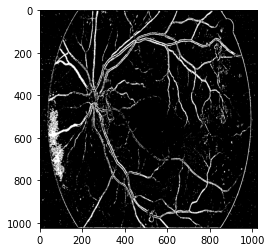

In [28]:
filepath = listdir(TEST_DIR)[3]

# Wczytywanie obrazu
test_img = cv2.imread(f'{TEST_DIR}/{filepath}', cv2.IMREAD_COLOR)
# Zmniejsz tak jak przy trenowaniu
test_img = cv2.resize(test_img, img_size)
# Wyciągnij zielony kanał
_, test_img, _ = cv2.split(test_img)
# Wyrównaj histogram kolorów
test_img = cv2.equalizeHist(test_img)

# Obraz wynikowy
result = np.zeros((test_img.shape[0], test_img.shape[1]))

# Predykcja dla każdego piksela
for x, row in enumerate(tqdm(test_img)):
    for y, _ in enumerate(row):
        # Wyciąganie predykcji
        result[x][y] = get_prediction(get_fragment(test_img, x, y, sample_size), model)

# Wyświetl obraz wynikowy
plt.imshow(result, cmap='gray')

#### 2. Cecha : Momenty Hu

  0%|          | 0/1024 [00:00<?, ?it/s]

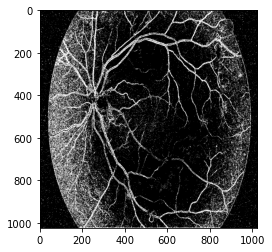

In [57]:
filepath = listdir(TEST_DIR)[3]

# Wczytywanie obrazu
test_img = cv2.imread(f'{TEST_DIR}/{filepath}', cv2.IMREAD_COLOR)
# Zmniejsz tak jak przy trenowaniu
test_img = cv2.resize(test_img, img_size)
# Wyciągnij zielony kanał
_, test_img, _ = cv2.split(test_img)
# Wyrównaj histogram kolorów
test_img = cv2.equalizeHist(test_img)

# Obraz wynikowy
result = np.zeros((test_img.shape[0], test_img.shape[1]))

# Predykcja dla każdego piksela
for x, row in enumerate(tqdm(test_img)):
    for y, _ in enumerate(row):
        # Wyciąganie predykcji
        result[x][y] = get_set_prediction(get_fragment(test_img, x, y, sample_size), hu_model)

# Wyświetl obraz wynikowy
plt.imshow(result, cmap='gray')